Caffe: MCMC on Images
===
I've managed to use PyMC to generate samples from the image space that are distributed according to a particular label.

My previous output was not fully correct. Although some parameter adjustment may still be necessary to produce the best possible results, this notebook illustrates the pipeline and features some analysis of results.

In [22]:
import sys
sys.path.insert(0, '/usr/lib/caffe/python')
import caffe

from pylab import *
%matplotlib inline

In [2]:
rcParams['image.cmap']=u'gray'
rcParams['image.interpolation']=u'none'

In [3]:
caffe.set_device(0)
caffe.set_mode_cpu()

In [4]:
# Load the pretrained, deployed network from file
net = caffe.Net('/thesis/exp/networks/mnist_lenet/deploy.prototxt',
                '/thesis/exp/networks/mnist_lenet/lenet.caffemodel',
                caffe.TEST)

In [5]:
import pickle

In [6]:
f = open('/thesis/exp/data/mnist/mnist.pkl')
mnist = pickle.load(f)
f.close()

In [7]:
trn_img,trn_lbl = mnist[0]
tst_img,tst_lbl = mnist[1]
cvd_img,cvd_lbl = mnist[2]

As before, we will be using the MNIST dataset and LeNet-based classifier.

In [8]:
import pymc

In [9]:
# Custom log-probability function based on network predictive strength
def targeted_logp(value, label, factor):
    # Reconstruct image from vector
    img = value.reshape(28,28,1)

    net.blobs['data'].data[0] = value
    net.forward()
    pred = net.blobs['pred'].data[0]

    p = pred[label]**factor # Add exponent to adjust shape of curve

    return np.log(p)


# Custom step method to produce images with pixel intensities bounded below at 0 and above at 1
class NormalPixels(pymc.Metropolis):
    def __init__(self, stochastic, tau, *args, **kwargs):
        self.dim = stochastic.value.shape
        self.tau = tau
        pymc.Metropolis.__init__(self, stochastic, *args, **kwargs)
    def propose(self):
        self.stochastic.value = pymc.rtruncnorm(self.stochastic.value, self.tau, 0, 1, self.dim)



# Function to extract samples from a single target label with given parameters
def sampleLabel(logp_function,initial_image,target_label,adjustment_factor,iter_params):
    print ""
    print "Sampling label",target_label,"with exponent",adjustment_factor
    digitImage = pymc.Stochastic(logp = logp_function,
                        doc='Image',
                        name='digitImage',
                        parents={'label': target_label, 'factor': adjustment_factor},
                        value = initial_image)
    
    M = pymc.MCMC([digitImage])
    M.use_step_method(NormalPixels,digitImage,10)
    M.sample(iter_params[0],iter_params[1],iter_params[2])
    
    return(M.trace('digitImage')[:])

In [10]:
def sampleAll(logp_function,initial_image,adjustment_factor,iter_params):
    X = [0]*10
    for i in range(10):
        X[i]=sampleLabel(logp_function,initial_image,i,adjustment_factor,iter_params)
    return X

In [11]:
# Function to get label activations for each of a list of images
def shoveThrough(imageBatch):
    out = np.zeros([len(imageBatch),10])
    # change this to forward_all based
    for i in range(len(imageBatch)):
        net.blobs['data'].data[0,0]=imageBatch[i]
        net.forward()
        out[i] = net.blobs['pred'].data[0]
    return out

We will take MCMC samples targeting each of our 10 labels, starting from a uniformly gray initial image.

In [17]:
X = sampleAll(targeted_logp,np.zeros([28,28])+0.5,4,(101000,1000,100))


Sampling label 0 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 159.1 sec
Sampling label 1 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 163.0 sec
Sampling label 2 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 192.2 sec
Sampling label 3 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 181.6 sec
Sampling label 4 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 169.7 sec
Sampling label 5 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 158.0 sec
Sampling label 6 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 163.4 sec
Sampling label 7 with exponent 4
 [-----------------100%-----------------] 101000 of 101000 complete in 156.5 sec
Sampling label 8 with exponent 4
 [-----------------100%-----------------] 101000 of 10

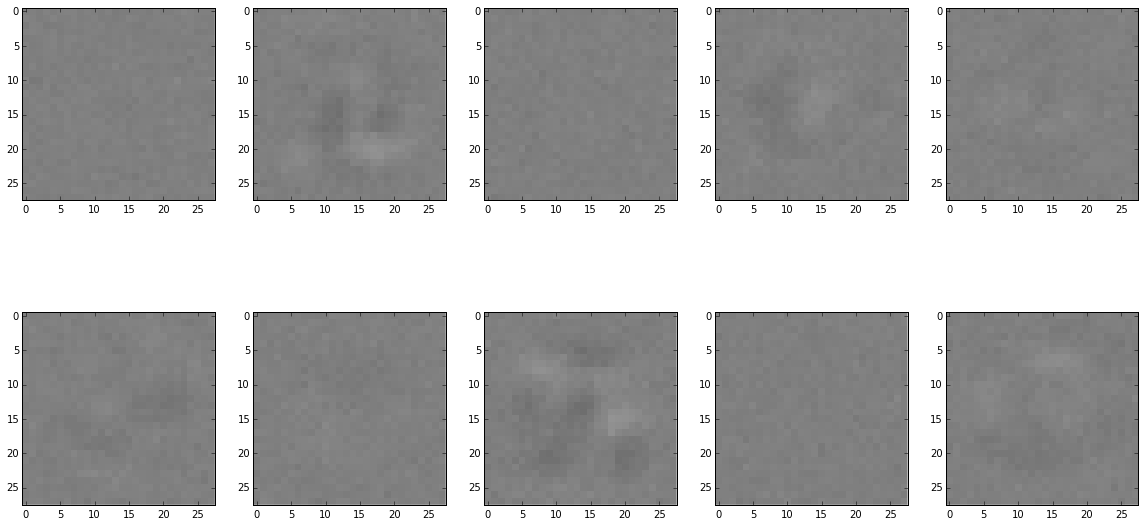

In [18]:
figure(figsize=(20,10))
for i in range(10):
    subplot(2,5,i+1)
    imshow(mean(X[i],0),vmin=0,vmax=1)

The mean images of our samples for each label are mostly gray. However, some patterns seem to appear. Let's plot again on a narrower range of pixel intensities.

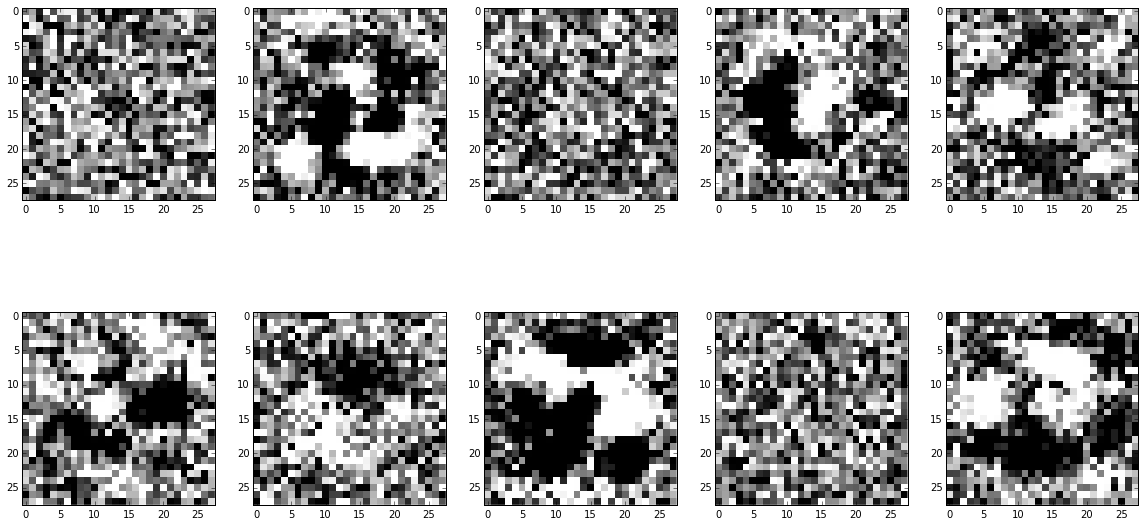

In [19]:
figure(figsize=(20,10))
for i in range(10):
    subplot(2,5,i+1)
    imshow(mean(X[i],0),vmin=0.49,vmax=0.51)

We are getting distinct visualizations for some digits. 1, 3, 4, 7 and 9 are clearly characterized; 5 and 6 to a lesser degree. There is no clear pattern for 0, 2 or 8, however.

What is the average response for each of our classes?

In [83]:
response = [shoveThrough(A) for A in X]

In [84]:
for i in range(10):
    print "The samples produced for label",i,"have average activation value",mean(response[i],0)[i],"for label",i

The samples produced for label 0 have average activation value 0.930540349603 for label 0
The samples produced for label 1 have average activation value 0.072096749262 for label 1
The samples produced for label 2 have average activation value 0.915562333465 for label 2
The samples produced for label 3 have average activation value 0.449210742354 for label 3
The samples produced for label 4 have average activation value 0.670085863322 for label 4
The samples produced for label 5 have average activation value 0.423660581388 for label 5
The samples produced for label 6 have average activation value 0.768405558527 for label 6
The samples produced for label 7 have average activation value 0.0349846715615 for label 7
The samples produced for label 8 have average activation value 0.999619169891 for label 8
The samples produced for label 9 have average activation value 0.308292462174 for label 9


Our samples are not good matches for the intended label in several cases.

---

It may be the case that some digits are recognized over more well-defined regions of the image space than others.

To test this, let's see what response we get when we feed a large number of random images into the network.

In [37]:
noiseBatch = np.random.rand(10000,28,28)

In [38]:
noisePred = shoveThrough(noiseBatch)

In [39]:
mean(noisePred,0)

array([ 0.91226082,  0.01994896,  0.90815346,  0.23311426,  0.54109893,
        0.25028665,  0.6647793 ,  0.00568601,  0.9997169 ,  0.14037748])

Raw noise uniformly distributed in [0,1] produces, on average, a 0.912 match for 0, a 0.908 match for 2, and a nearly perfect match for 8. This explains why our sample means had no strong pattern in these cases.

The MCMC samples do better than noise at matching their intended label in most of these cases. However, they are still much worse than natural images for most labels. This may be due to the fact that our MCMC routine takes proposed samples from the *entire* image space, while our natural images are drawn from a small subspace of smooth figures on a black background.

A t-SNE visualization of this fact is presented a different workbook.

In [21]:
pickle.dump(X,open('/thesis/exp/output/mnist_MCMC_samples.pkl','wb'))